In [2]:
%matplotlib inline

In [30]:
import numpy as np
import pandas as pd
import pickle as pkl
from itertools import product
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tqdm import tqdm
from matplotlib import pyplot as plt
from datetime import timedelta, datetime
from joblib import delayed, Parallel
from copy import copy

from core import  do_simulation
from helpers import Params, T, get_T1_and_T2, R0, plot_total, DATE_FORMAT, total_to_csv

from const import STATE, COLORS, NUM_STATES,  STATES


In [3]:
p0_time = pkl.load(open('output/p0_time.pkl', 'rb'))
lockdown_time = T('23/01/2020')

In [5]:
params_before = pkl.load(
    open('output/params_before_lockdown.pkl', 'rb')
)

params_after = pkl.load(
    open('output/params_after_lockdown.pkl', 'rb')
)

In [19]:
bed_info_raw = [
    (p0_time, 3000), # 3000),
    (T('25/01/2020'), 1000), # 4000),    
    (T('31/01/2020'), 6000), # 10000),
    (T('04/02/2020'), 1000), #  11000),
    (T('07/02/2020'), 2000), # 13000)
    (T('11/02/2020'), 6000),  # 19000
    (T('17/02/2020'), 11000),  # 28000
    (T('21/02/2020'), 11000),  # 39000
]
bed_info = [((d-p0_time).days, n) for d, n in bed_info_raw]

In [33]:
total_days =  360

In [20]:
def one_run(delta_t, total_days=360):
    delta = timedelta(days=delta_t)
    assumed_ld_date = lockdown_time + delta
    days_to_p0 = (assumed_ld_date - p0_time).days
    print('lockdown date',  assumed_ld_date)
    params = Params(
        total_population=params_before.total_population,
        initial_num_E=params_before.initial_num_E,
        initial_num_I=params_before.initial_num_I,
        initial_num_M=params_before.initial_num_M,    
        alpha=[(0, params_before.alpha), (days_to_p0, params_after.alpha)],
        beta=[(0, params_before.beta), (days_to_p0, params_after.beta)],
        mu_ei=params_before.mu_ei,
        x0_pt=params_before.x0_pt,
        k_pt=params_before.k_pt,
        mu_mo=params_before.mu_mo,
        k_days=params_before.k_days
    )

    total, _, _, _ = do_simulation(total_days, bed_info, params, verbose=0)    
    return assumed_ld_date, delta_t, total

In [21]:
rows = Parallel(n_jobs=-1)(delayed(one_run)(delta_t, total_days) for  delta_t in  range(-7, 8) if delta_t != 0)

-7
2020-01-16
-6
2020-01-17
-5
2020-01-18
-4
2020-01-19
-3
2020-01-20
-2
2020-01-21
-1
2020-01-22
1
2020-01-24
2
2020-01-25
3
2020-01-26
4
2020-01-27
5
2020-01-28
6
2020-01-29
7
2020-01-30


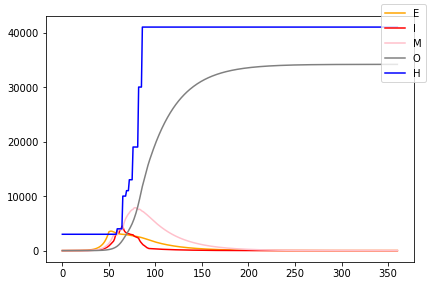

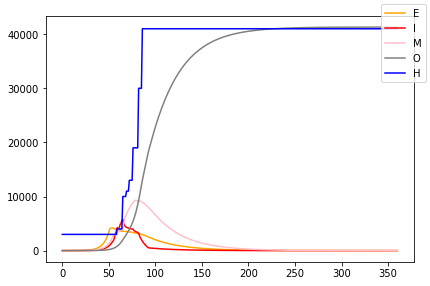

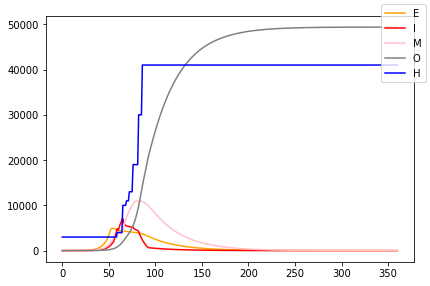

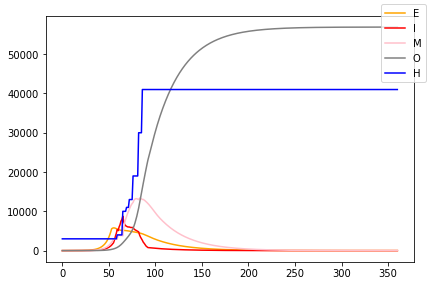

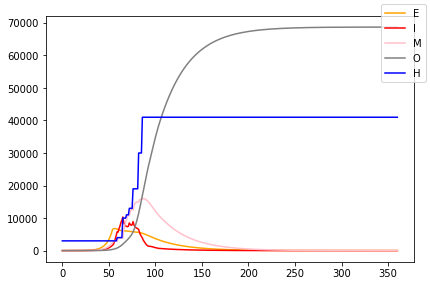

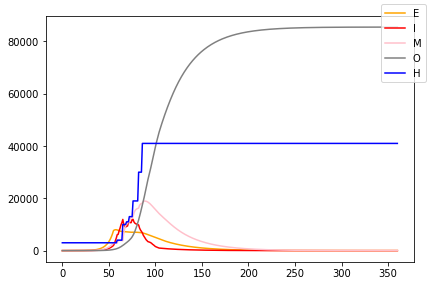

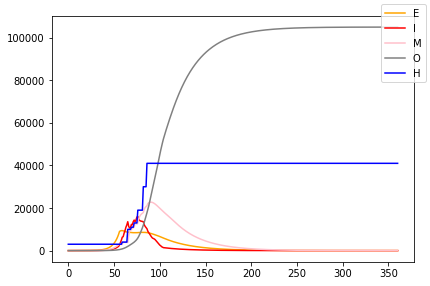

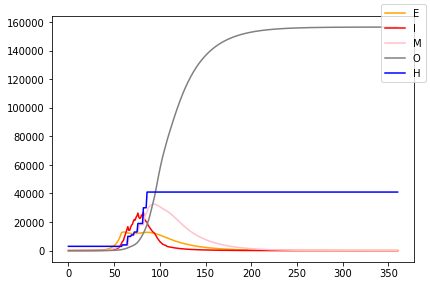

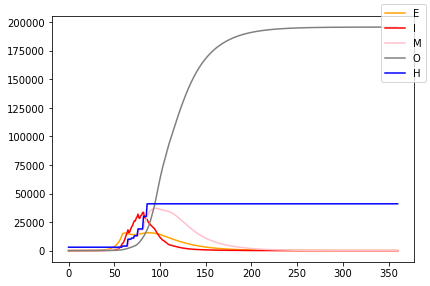

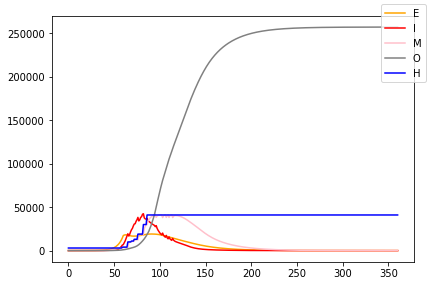

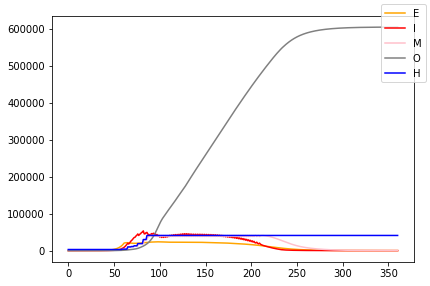

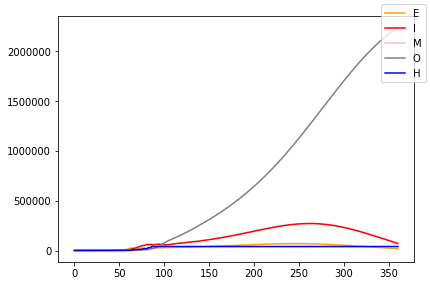

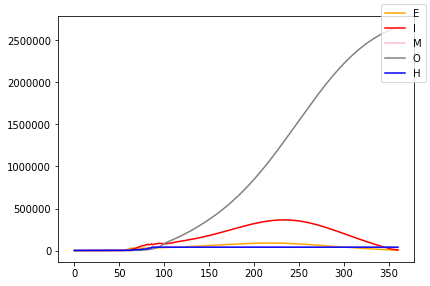

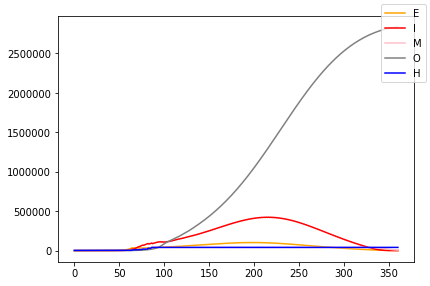

In [34]:
for dt, days, total in rows:
    dt_str = dt.strftime('%Y-%m-%d')
    print(days)
    print(dt_str)
    fig, ax = plot_total(total)
    fig.savefig(f'figs/advance-or-delay-lockdown/{dt_str}({days}).pdf')
    
    total_to_csv(p0_time, total_days, total, f'output/tbl/advance-or-delay-lockdown/{dt_str}({days}).csv')